In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

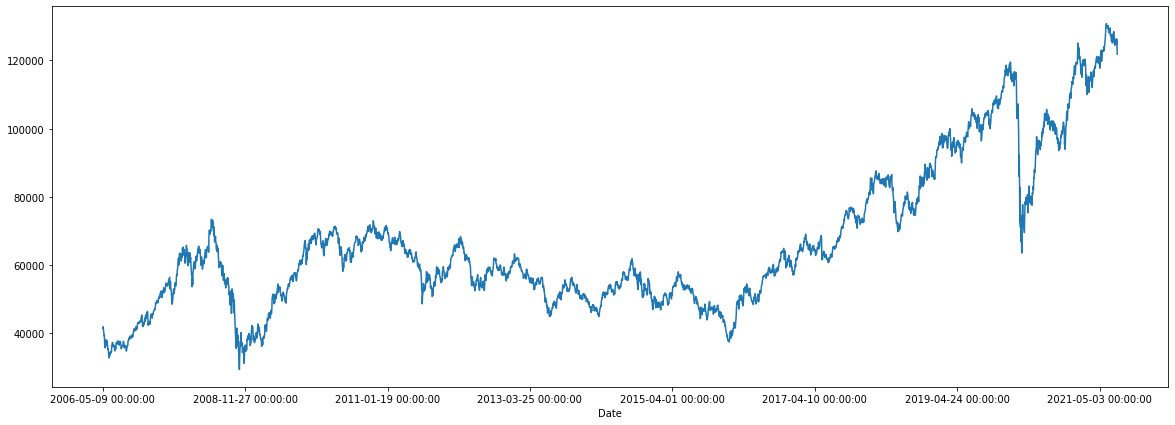

In [2]:
df = pd.read_csv('src/Base Logistic.csv')
df = df.set_index('Date')
df['IBOV'].plot(figsize=(20,7))
plt.savefig('Images/Hist IBOV')

In [3]:
#Adicionando variaveis aleatorias

#Resetando df2
df2 = df.copy()

#Calculo do ln(retorno) anual da variavel IBOV. Usasse o Ln retorno para normalizar a distribuição uma vez que ela tem limite na cauda esquerda (o valor mínimo do índice é 0), mas não na direite, já que não há limite para a alta.
df2['LogReturn'] = np.log(df2['IBOV']/df2['IBOV'].shift(1))*252

#Dividindo pela raiz de 252 já que multiplicamos o Log(retorno) por 252. Como a variância é o quadrado do desvio padrão é necessário dividiz pela raiz de periodo.
df2['AvgLnStd'] = df2['LogReturn'].rolling(window=30).std()/(252**(1/2))

#Criando a médias móveis curtas e longas para refletir movimentos de curto e longo prazo.
df2['AvgLnMean10'] = df2['LogReturn'].rolling(window=10).mean()
df2['AvgLnMean30'] = df2['LogReturn'].rolling(window=30).mean()
df2['AvgLnMean60'] = df2['LogReturn'].rolling(window=60).mean()
df2['AvgLnMean90'] = df2['LogReturn'].rolling(window=90).mean()
df2['AvgLnMean180'] = df2['LogReturn'].rolling(window=180).mean()

#Variavel booleana para ver se o índice cresceu ou não. Utilizo o Shift(-1) para ver se o dia de amanhã é maior que o de hoje.
df2['Y'] = np.where(df2['IBOV'].shift(-1)>df2['IBOV'],1,0)

#Criando DataFrame final descartando as primeiras 180 linhas, já que retornan erro para a média movel mais longa e a última linha já que ela não tem valor futuro para ver se teve alta ou não.
df3 = df2[180:-1]
df3 = df3.reset_index().drop(['Date'],axis=1)
df3.tail(5)

,IBOV,LogReturn,AvgLnStd,AvgLnMean10,AvgLnMean30,AvgLnMean60,AvgLnMean90,AvgLnMean180,Y
3377,125052.78,-2.194746,0.144153,-0.075453,-0.330828,0.136548,0.238287,0.379379,1
3378,126003.86,1.909317,0.145980,-0.315995,-0.226068,0.202747,0.279858,0.372286,0
3379,124612.03,-2.799062,0.147410,-0.708995,-0.368993,0.197291,0.187291,0.395384,1
3380,126285.59,3.361876,0.153535,-0.419710,-0.249387,0.242187,0.266128,0.384173,0
3381,125675.33,-1.220712,0.153120,-0.356897,-0.236209,0.274936,0.218969,0.350132,0


In [4]:
#Analisando o resultado.

movimento = pd.DataFrame(df3['Y'].value_counts())
movimento['Mov.'] = ('Alta','Baixa')
movimento = movimento.set_index('Mov.')
movimento = movimento.rename(columns={'Y': 'Quantidade'})
movimento['Proporção (%)'] = round(movimento['Quantidade']/sum(movimento['Quantidade'])*100,2)
movimento

,Quantidade,Proporção (%)
Mov.,,
Alta,1750,51.74
Baixa,1632,48.26


Média dos Retornos: 7.68%
MDesv. Padrãodos RLogs etornos: 29.09%


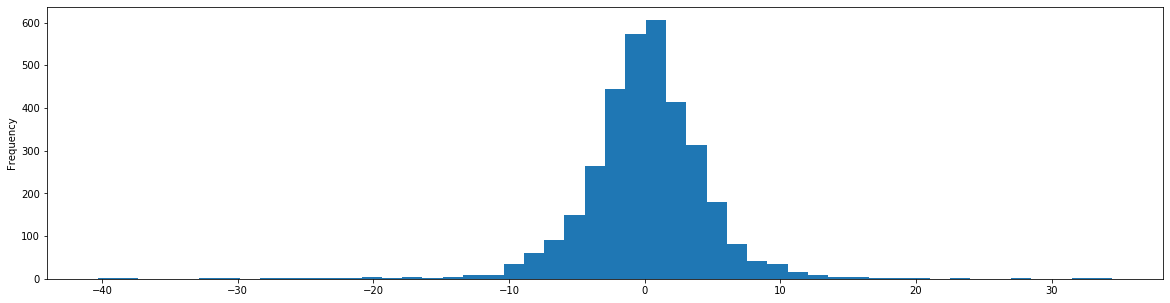

In [5]:
#plotando o histograma dos log retornos.
df3['LogReturn'].plot.hist(bins=50,figsize=(20,5))
plt.savefig('Images/Histograma Ln Retornos')
print('Média dos Retornos: {:.2f}%'.format(round((np.exp(df3['LogReturn'].mean())-1)*100,2)))
print('MDesv. Padrãodos RLogs etornos: {:.2f}%'.format(round(df3['LogReturn'].std()*100/(252**(1/2)),2)))

In [6]:
#Importando bibliotecas para o modelo.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import stats

In [7]:
#Criando dataframes para os testes e para o calculo do resultado.
x = df3.drop(['IBOV','Y'],axis=1)
y = df3['Y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=27)

In [8]:
#Trainando o modelo.
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

#Obtendo resultado com a amostra de teste.
y_pred = logreg.predict(x_test)

In [9]:
#Matrix de Confusão.
MatrizConfusao= metrics.confusion_matrix(y_test, y_pred)
MatrizConfusao = pd.DataFrame(MatrizConfusao).rename(columns={0:'Alta',1:'Baixa'},index={0:'Pred_Alta',1:'Pred_Baixa'})
MatrizConfusao

,Alta,Baixa
Pred_Alta,114,380
Pred_Baixa,99,422


In [10]:
#Recall é a soma dos verdadeiros psitivos sobre oo total de valores positivos.
recall = MatrizConfusao.iloc[0,0]/(MatrizConfusao.iloc[0,0]+MatrizConfusao.iloc[1,0])
print('Recall: {:.2f}%'.format(recall*100))

#Precisão é a soma dos verdadeiros positivos sobre o total de valores previstos como positivos pelo modelo.
precision = MatrizConfusao.iloc[0,0]/(MatrizConfusao.iloc[0,0]+MatrizConfusao.iloc[0,1])
print('Precisão: {:.2f}%'.format(precision*100))

#Acuracidade é a taxa de acerto do modelo, ou seja todas as classificações corretas sobre a quantidade total de previsões.
#Outra forma de obeter a acuracidade do modelo é por meio de função :logreg.score(x_test, y_test)
accuracy = (MatrizConfusao.iloc[0,0]+MatrizConfusao.iloc[1,1])/sum(MatrizConfusao.sum())
print('Acuracidade: {:.2f}%'.format(accuracy*100))

Recall: 53.52%
Precisão: 23.08%
Acuracidade: 52.81%


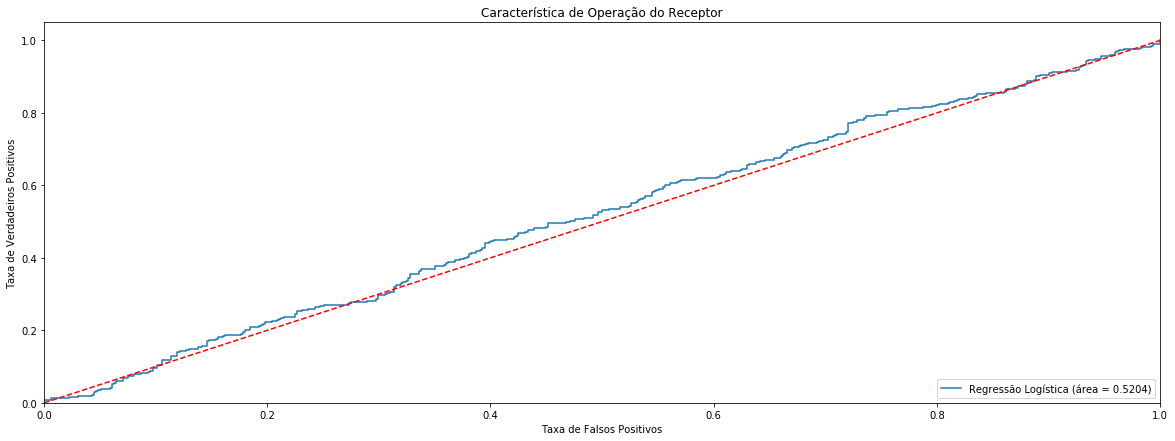

<Figure size 432x288 with 0 Axes>

In [11]:
#Plotando Gráfico ROC com AUC na legenda. AUC = Área de baixo da curva de ROC.
roc_area = metrics.roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure(figsize=(20,7))
plt.plot(fpr, tpr,label='Regressão Logística (área = {:.4f})'.format(roc_area))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Característica de Operação do Receptor')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC')

In [12]:
parametros = pd.DataFrame(logreg.intercept_).T
parametros = parametros.append(pd.DataFrame(logreg.coef_).T)
parametros = parametros.rename(columns={0:'Valores'})
parametros = parametros.reset_index().drop(['index'],axis=1)
variaveis = ['Intercepção']
for i in x_train.columns.to_list():
    variaveis.append(i)
parametros['Parametros'] = pd.DataFrame(variaveis)
parametros = parametros.set_index('Parametros')
parametros= parametros.T
parametros

Parametros,Intercepção,LogReturn,AvgLnStd,AvgLnMean10,AvgLnMean30,AvgLnMean60,AvgLnMean90,AvgLnMean180
Valores,-0.012145,-0.012323,0.270093,-0.0071,0.070698,-0.052322,-0.090114,0.327662


In [13]:
def sumLogLikelihood(baseDataFrame,coeficients,intercept,y):
     r = np.dot(baseDataFrame,np.array(coeficients).T)+intercept
     r = 1/(1+np.exp(-r))
     r = pd.DataFrame(r)
     r['y'] = pd.DataFrame(y.values)
     r['result'] = np.log(np.where(r['y']==1,r[0],1-r[0]))
     result = r['result'].sum()
     return result

def sumAvgLogLikelihood(y):
     r = np.where(y==1,sum(y)/len(y),1-sum(y)/len(y))
     r = np.log(r)
     return r.sum()

def mcFaddensPseudoRSquare(baseDataFrame,coeficients,intercept,y):
     llFit = sumLogLikelihood(baseDataFrame,coeficients,intercept,y)
     llFull = sumAvgLogLikelihood(y)
    
     return (llFull - llFit)/llFull

print('McFaddens Pseudo R²: {:.10f}'.format(mcFaddensPseudoRSquare(x_test,logreg.coef_,logreg.intercept_,y_test)))


McFaddens Pseudo R²: -0.0005989114


In [14]:
def pValue(baseDataFrame,coeficients,intercept,y):
    r= 2*(sumLogLikelihood(baseDataFrame,coeficients,intercept,y) - sumAvgLogLikelihood(y))
    return r

p = pValue(x_test,logreg.coef_,logreg.intercept_,y_test)
estatisticaDoTeste = stats.chi2.pdf(p , len(x_train.columns))

print('P-Value para o teste Qui-Quadrado: {:.2f}'.format(p))
print('Estatistica do teste Qui-Quadrado: {:.2f}'.format(estatisticaDoTeste))

P-Value para o teste Qui-Quadrado: -0.84
Estatistica do teste Qui-Quadrado: 0.00


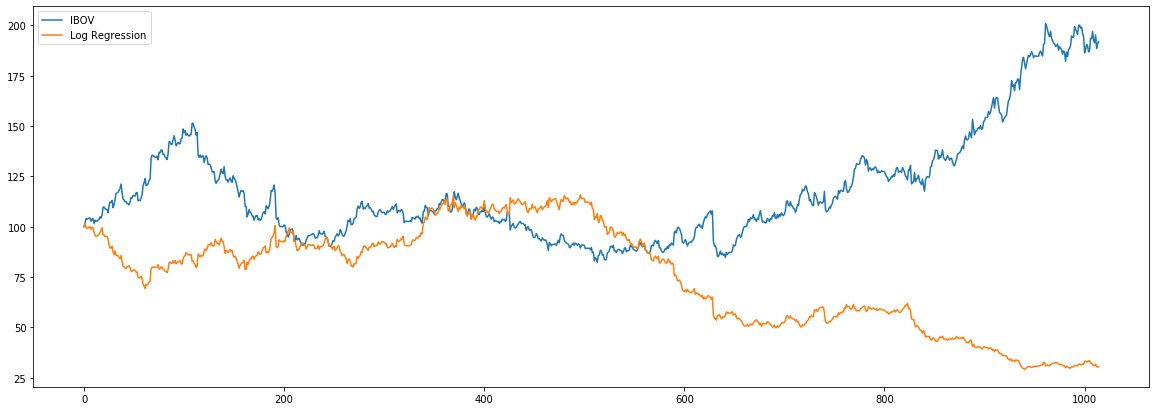

In [15]:
comparacao = pd.DataFrame(np.exp(x_test['LogReturn']/252))
comparacao = comparacao.reset_index().drop('index',axis=1)
comparacao = comparacao.rename(columns={'LogReturn':'IBOV'})
comparacao['IBOV Acumulado'] = np.cumprod(comparacao['IBOV'])
comparacao['Lg Regression'] = pd.DataFrame(y.values)
comparacao['Lg Regression'] = np.where(comparacao['Lg Regression']==1,comparacao['IBOV'],1-(comparacao['IBOV']-1))
comparacao['Lg Regression Acumulado'] = np.cumprod(comparacao['Lg Regression'])
comparacao = comparacao.drop(['IBOV','Lg Regression'],axis=1)
comparacao = comparacao/comparacao.iloc[0]*100
comparacao = comparacao.rename(columns={'IBOV Acumulado':'IBOV','Lg Regression Acumulado':'Log Regression'})
comparacao.plot(figsize=(20,7))
plt.savefig('Images/IBOV x Modelo')

In [16]:
rIbov = comparacao.iloc[-1][0]-100
rRegression = comparacao.iloc[-1][1]-100
stdIbov = (comparacao['IBOV']/comparacao['IBOV'].shift(1)).std()*(252**(1/2))*100
stdRegression = (comparacao['Log Regression']/comparacao['Log Regression'].shift(1)).std()*(252**(1/2))*100

print('Rendimento acumulado do IBOV: {:.2f}%'.format(rIbov))
print('Rendimento acumulado do modelo: {:.2f}%'.format(rRegression))
print('Risco do IBOV: {:.2f}%'.format(stdIbov))
print('Risco do modelo: {:.2f}%'.format(stdRegression))

Rendimento acumulado do IBOV: 91.96%
Rendimento acumulado do modelo: -69.63%
Risco do IBOV: 28.00%
Risco do modelo: 27.98%
